# 01 Importing Libraries and Data Q2

In [1]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm 
import os
import warnings 

warnings.filterwarnings("ignore") 

plt.style.use('fivethirtyeight') 

In [2]:
# Configure API key 
quandl.ApiConfig.api_key = 'HaXNfDDgSJQVfMfSmHAJ'

In [3]:
# Importing the Federal Reserve Economic Data "Real Potential Gross Domestic Product" variable.
data = quandl.get('FRED/GDPPOT')

In [4]:
data.head(5)

,Value
Date,
1949-01-01,2102.982630
1949-04-01,2130.581305
1949-07-01,2159.340530
1949-10-01,2186.844859
1950-01-01,2216.058359


In [5]:
data.shape

(332, 1)

In [6]:
data.columns

Index(['Value'], dtype='object')

In [7]:
type(data)

pandas.core.frame.DataFrame

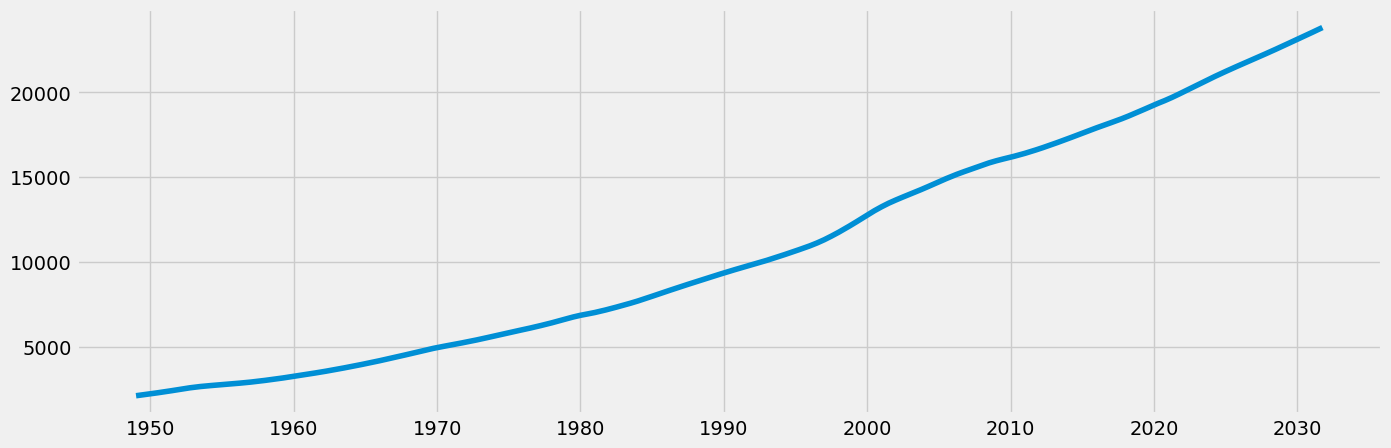

In [8]:
# Plot the data using matplotlib.
plt.figure(figsize=(15,5), dpi=100) 
plt.plot(data)

# 02 Subsetting, wrangling, and cleaning time-series data

In [9]:
# Reset index so that you can use the "Date" column as a filter
data_2 = data.reset_index()

In [10]:
data_2.head()

,Date,Value
0,1949-01-01,2102.982630
1,1949-04-01,2130.581305
2,1949-07-01,2159.340530
3,1949-10-01,2186.844859
4,1950-01-01,2216.058359


In [11]:
data_sub = data_2.loc[(data_2['Date'] >= '2006-01-01') & (data_2['Date'] < '2021-07-02')]

In [12]:
data_sub.shape

(63, 2)

In [13]:
data_sub.head()

,Date,Value
228,2006-01-01,15079.78428
229,2006-04-01,15163.22431
230,2006-07-01,15243.01082
231,2006-10-01,15318.99905
232,2007-01-01,15394.59155


In [14]:
# Set the "Date" column as the index
from datetime import datetime
data_sub['datetime'] = pd.to_datetime(data_sub['Date']) 
data_sub = data_sub.set_index('datetime') 
data_sub.drop(['Date'], axis=1, inplace=True) 
data_sub.head()

,Value
datetime,
2006-01-01,15079.78428
2006-04-01,15163.22431
2006-07-01,15243.01082
2006-10-01,15318.99905
2007-01-01,15394.59155


I chose a subset that corresponds to the Happiness Score data i had been working on (2006-2021). I cheched that GDP data was last updated on 7/2/21, so I chose that as my last data point, instead of going for entire 2021.

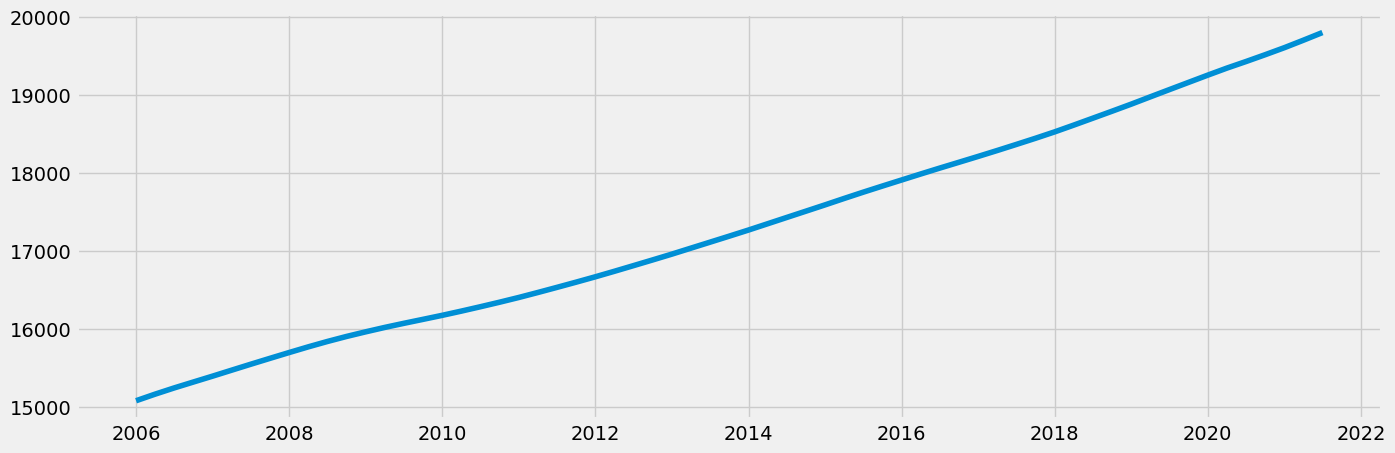

In [15]:
# Plot the new data set Q4
plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_sub)

In [16]:
# Check for missing values (you shouldn't have any)
data_sub.isnull().sum() 

Value    0
dtype: int64

In [17]:
# Check for duplicates
dups = data_sub.duplicated()
dups.sum()

0

# 03 Decomposing Q5

In [18]:
# Decompose the time series using an additive model
decomposition = sm.tsa.seasonal_decompose(data_sub, model='additive')

In [19]:
from pylab import rcParams 
rcParams['figure.figsize'] = 18, 7

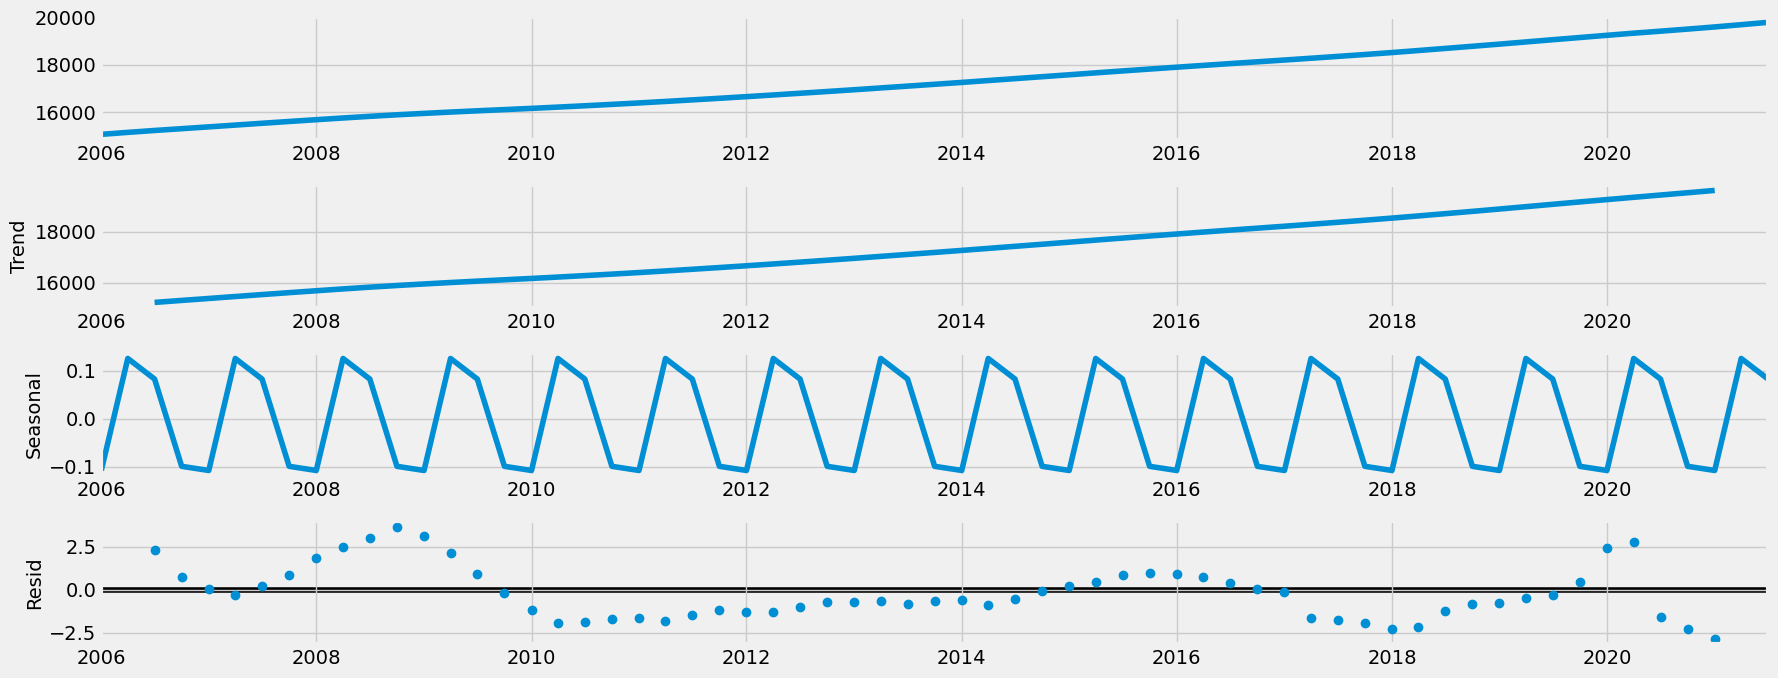

In [20]:
# Plot the separate components
decomposition.plot()
plt.show()

The level and trend do not differ much. The dominant trend is gradual increase. There is some seasonality in our data, peaking in 2nd and 3rd quarters (Apr and Jul reporting) and dropping in 1st and 4th quarters (Jan and Oct). The noise comes mostly around 2008 financial crisis (followed by prolonged sluggish recovery) and around 2020 Covid period. 

The presence of a trend and seasonality implies the series is non-stationary.

# 04 Testing for stationarity Q6

In [21]:
# Import the adfuller() function
from statsmodels.tsa.stattools import adfuller 

# Define the function
def dickey_fuller(timeseries): 
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(data_sub['Value'])

Dickey-Fuller Stationarity test:
Test Statistic                  3.389325
p-value                         1.000000
Number of Lags Used            11.000000
Number of Observations Used    51.000000
Critical Value (1%)            -3.565624
Critical Value (5%)            -2.920142
Critical Value (10%)           -2.598015
dtype: float64


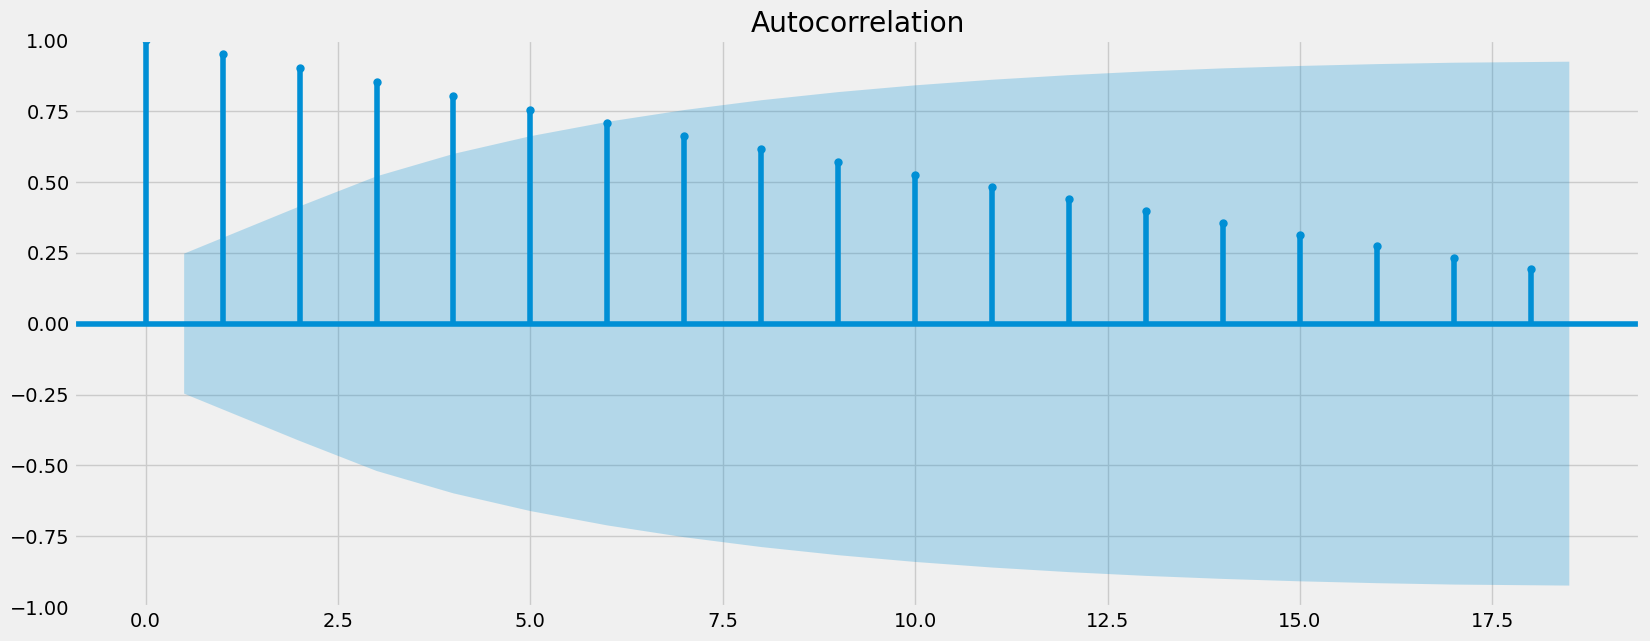

In [22]:
# Check out a plot of autocorrelations
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
plot_acf(data_sub)
plt.show()

The test statistic (3.39) is larger than the critical value (-2.92 at 5% level of significance), so I can’t reject the null hypothesis. This means there is a unit root in the data, and it is non-stationary. 

Autocorrelation chart also shows that the data is non-stationary. 

# 05 Stationarizing the Data Q7

In [23]:
data_diff = data_sub - data_sub.shift(1) 

In [24]:
# Removing the missing values 
data_diff.dropna(inplace = True) 

In [25]:
data_diff.head()

,Value
datetime,
2006-04-01,83.44003
2006-07-01,79.78651
2006-10-01,75.98823
2007-01-01,75.59250
2007-04-01,75.65526


In [26]:
data_diff.columns

Index(['Value'], dtype='object')

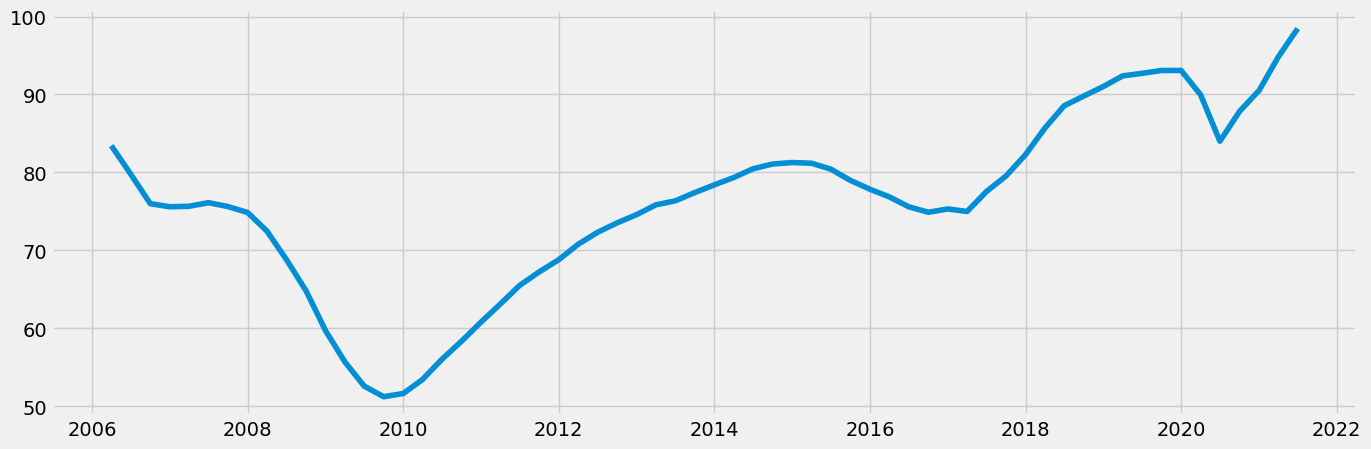

In [27]:
# Checking the time-series curve
plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [28]:
# Conducting Dickey-Fuller test again 
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                 -1.176157
p-value                         0.683767
Number of Lags Used            10.000000
Number of Observations Used    51.000000
Critical Value (1%)            -3.565624
Critical Value (5%)            -2.920142
Critical Value (10%)           -2.598015
dtype: float64


The test statistic (-1.18) is still larger than the critical value (-2.92 at 5% level of significance), so I need to repeat differencing. P-value is also still above 0.05.

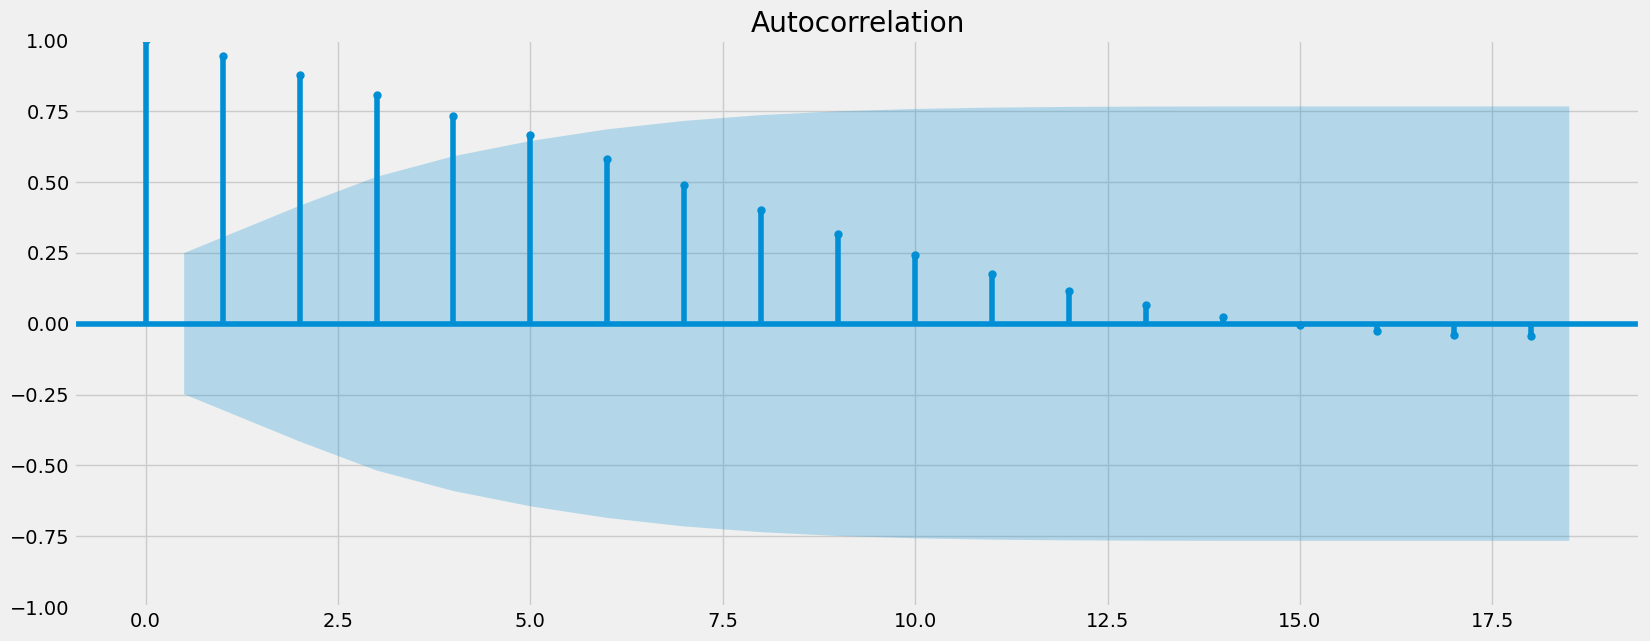

In [29]:
# Checking Autocorrelation Q9
plot_acf(data_diff)
plt.show()

In [30]:
# Repeating differencing Q8
data_diff_2 = data_diff - data_diff.shift(1) 

In [31]:
# Removing the missing values 
data_diff_2.dropna(inplace = True) 

In [32]:
data_diff_2.head()

,Value
datetime,
2006-07-01,-3.65352
2006-10-01,-3.79828
2007-01-01,-0.39573
2007-04-01,0.06276
2007-07-01,0.46031


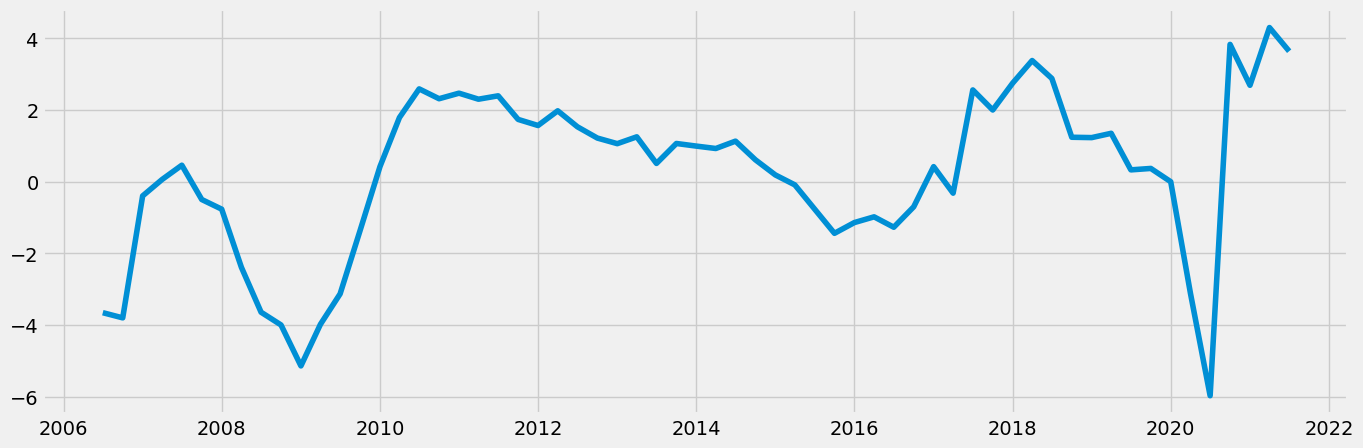

In [33]:
# Checking the time-series curve
plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff_2)

In [34]:
# Conducting Dickey-Fuller test again 
dickey_fuller(data_diff_2)

Dickey-Fuller Stationarity test:
Test Statistic                 -2.951088
p-value                         0.039722
Number of Lags Used            11.000000
Number of Observations Used    49.000000
Critical Value (1%)            -3.571472
Critical Value (5%)            -2.922629
Critical Value (10%)           -2.599336
dtype: float64


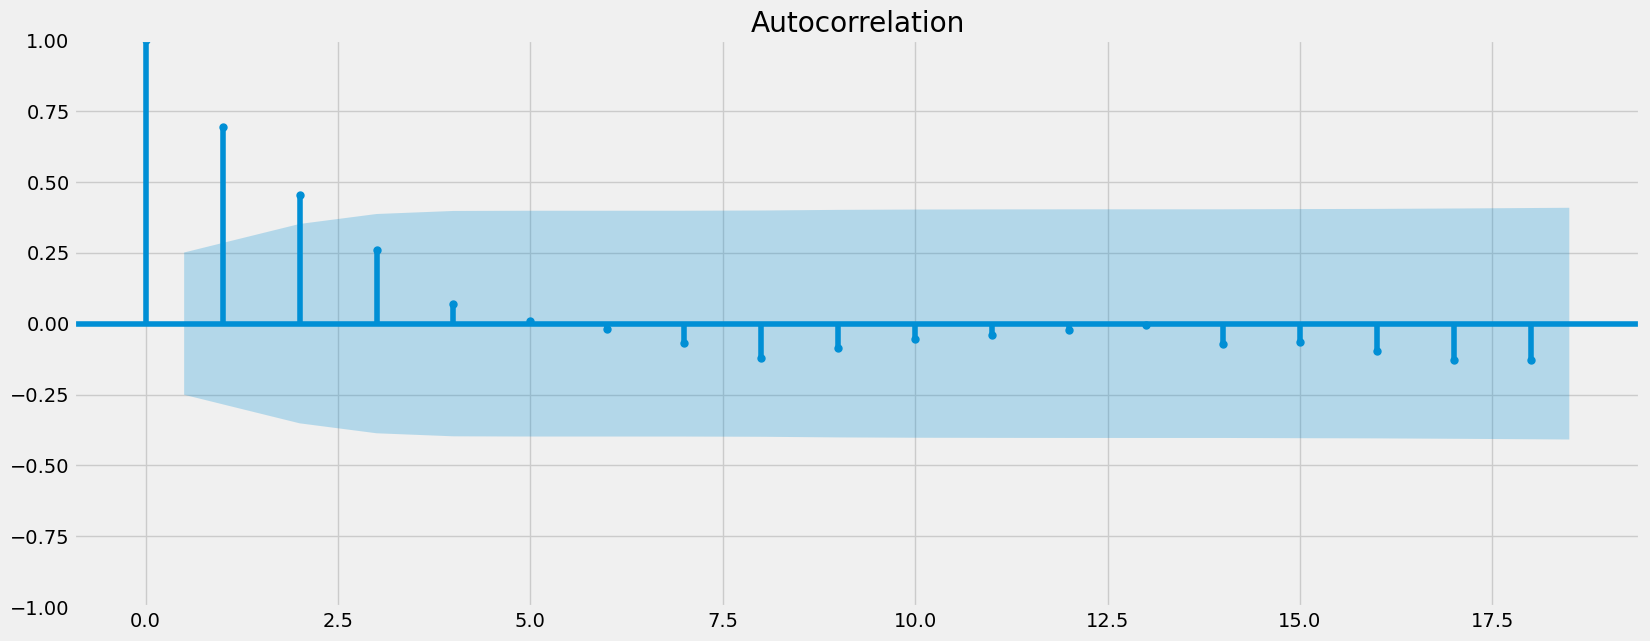

In [35]:
# Checking Autocorrelation Q9
plot_acf(data_diff_2)
plt.show()

The test statistic (-2.96) is now smaller than the critical value (-2.92 at 5% level of significance), so I can reject the null hypothesis. This means the data is non-stationary. 

Autocorrelation chart also confirms that. 